# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import random
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(97496, 22)
CPU times: user 98.6 ms, sys: 34.4 ms, total: 133 ms
Wall time: 139 ms


,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0,...,Cardnum_unique_count_for_card_state_3,Cardnum_unique_count_for_card_zip_3,Merchnum_desc_Zip_total_3,Cardnum_unique_count_for_Merchnum_3,Cardnum_actual/toal_1,Cardnum_unique_count_for_card_state_7,Cardnum_actual/max_0,Card_dow_unique_count_for_merch_state_1,Recnum,Fraud
0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.0,...,1,1,3.62,1,1.0,1,1.0,1,1,0
1,1,31.42,0.033333,31.42,0.000011,0.000049,31.42,31.42,1,1.0,...,1,1,31.42,1,1.0,1,1.0,1,2,0
2,1,178.49,0.033333,178.49,0.000011,0.000049,178.49,178.49,1,1.0,...,1,1,178.49,1,1.0,1,1.0,1,3,0
3,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.0,...,1,1,3.62,1,1.0,1,1.0,1,4,0
4,1,7.24,0.033333,3.62,0.016667,0.071429,7.24,7.24,1,0.5,...,1,1,7.24,1,0.5,1,1.0,1,5,0


In [3]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 5 # Vary between 5 and 10

# vars.rename(columns={'record':'Recnum'},inplace=True)
# vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
detect_rate = .03
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'Cardnum_unique_count_for_card_state_1',
 'Card_Merchdesc_State_total_7',
 'Cardnum_count_1_by_30',
 'Cardnum_max_14',
 'Card_dow_vdratio_0by60']

In [4]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60
0,1,0,1,3.62,0.033333,3.62,0.000011
1,2,0,1,31.42,0.033333,31.42,0.000011
2,3,0,1,178.49,0.033333,178.49,0.000011
3,4,0,1,3.62,0.033333,3.62,0.000011
4,5,0,1,7.24,0.033333,3.62,0.016667


In [5]:
vars.shape

(97496, 7)

In [6]:
vars['Fraud'].sum()

2047

In [7]:
print("fraud rate in data is",vars['Fraud'].sum()/len(vars))

fraud rate in data is 0.020995733158283417


In [8]:
vars.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60
0,1,0,1,3.62,0.033333,3.62,0.000011
1,2,0,1,31.42,0.033333,31.42,0.000011
2,3,0,1,178.49,0.033333,178.49,0.000011
3,4,0,1,3.62,0.033333,3.62,0.000011
4,5,0,1,7.24,0.033333,3.62,0.016667
5,6,0,1,3.67,0.033333,3.67,0.000011
6,7,0,1,3.62,0.033333,3.62,0.000011
7,8,0,1,230.32,0.033333,230.32,0.000011
8,9,0,1,62.11,0.033333,62.11,0.000011
9,10,0,1,10.86,0.033333,3.62,0.016667


In [9]:
vars.shape

(97496, 7)

In [10]:
vars.describe()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60
count,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000
mean,48915.137247,0.020996,1.724266,676.571639,0.008823,1194.385741,0.003231
std,28262.212670,0.143371,1.568565,4074.921736,0.008372,1856.894526,0.004996
min,1.000000,0.000000,1.000000,0.010000,0.000078,0.140000,0.000007
25%,24428.750000,0.000000,1.000000,52.500000,0.003226,307.000000,0.000152
50%,48916.000000,0.000000,1.000000,189.000000,0.005556,801.660000,0.000370
75%,73402.250000,0.000000,2.000000,590.000000,0.011111,1743.000000,0.004762
max,97852.000000,1.000000,21.000000,306633.410000,0.033333,47900.000000,0.016667


In [11]:
# find the row i vars that corresponds to 11/1 for the oot
test = vars[vars['Recnum'] > 85264]
test.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60
84935,85265,0,1,174.61,0.016667,225.00,0.000074
84936,85266,0,1,53.00,0.002778,395.00,0.000278
84937,85267,0,1,25.00,0.004762,531.25,0.000417
84938,85268,0,1,97.17,0.004762,395.04,0.000194
84939,85269,0,1,6.51,0.016667,6.51,0.000167
84940,85270,0,1,170.00,0.016667,170.00,0.000260
84941,85271,0,1,250.00,0.002564,250.00,0.000149
84942,85272,0,1,15.00,0.016667,103.60,0.000167
84943,85273,0,1,300.00,0.006667,2105.00,0.000024
84944,85274,0,1,133.20,0.002564,268.20,0.001042


In [12]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [13]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60
count,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000
mean,1.724266,676.571639,0.008823,1194.385741,0.003231
std,1.568565,4074.921736,0.008372,1856.894526,0.004996
min,1.000000,0.010000,0.000078,0.140000,0.000007
25%,1.000000,52.500000,0.003226,307.000000,0.000152
50%,1.000000,189.000000,0.005556,801.660000,0.000370
75%,2.000000,590.000000,0.011111,1743.000000,0.004762
max,21.000000,306633.410000,0.033333,47900.000000,0.016667


In [14]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [15]:
# use this to cap variables. For some problems it helps
Clip = 10

In [16]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X - X.mean()) / X.std()
X.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60
count,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04
mean,-3.469048e-17,2.623650e-18,6.996400e-18,1.836555e-17,2.084344e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.651796e-01,-3.346282e-01,-1.044448e+00,-7.194261e-01,-6.452992e-01
25%,-4.651796e-01,-3.065413e-01,-6.685133e-01,-5.318162e-01,-6.163866e-01
50%,-4.651796e-01,-2.335016e-01,-3.902418e-01,-2.293881e-01,-5.725768e-01
75%,1.782986e-01,-1.893059e-02,2.733285e-01,3.461339e-01,3.065090e-01
max,1.009425e+01,2.183188e+01,2.927610e+00,1.136351e+01,2.689572e+00


In [17]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum = 85264
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]
Y_oot.sum()

Fraud    297
dtype: int64

## Look at PCA

In [18]:
len(X_trntst.columns)

5

In [19]:
X_trntst_save = X_trntst.copy()

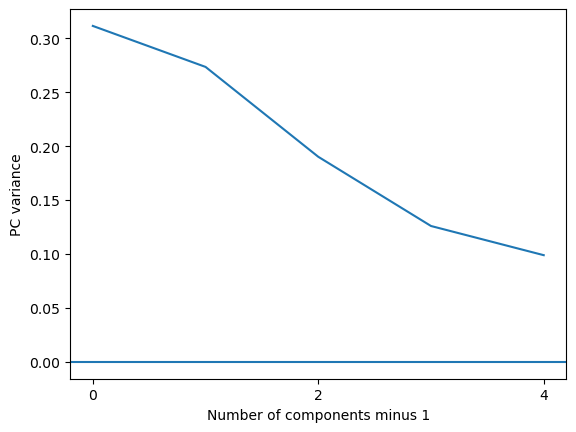

In [20]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [21]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-0.192408,-1.785289,1.544620,2.004001
1,-0.177329,-1.769850,1.549813,2.005548
2,-0.097557,-1.688174,1.577286,2.013729
3,-0.192408,-1.785289,1.544620,2.004001
4,1.419579,-3.269991,1.682986,-0.464201


In [22]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4
85264,-0.230638,0.126672,-0.533912,-0.411737
85265,0.666272,-2.467489,1.609296,0.779516
85266,0.178396,0.787423,0.749089,0.512504
85267,-0.213796,0.714999,-0.570284,0.294136
85268,-0.840877,0.456756,0.113237,-0.046825


In [23]:
X_trntst.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60
count,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000
mean,0.004006,0.002794,-0.013411,0.003866,0.000122
std,1.007299,1.029148,0.996083,0.988241,0.999618
min,-0.465180,-0.334628,-1.044448,-0.719426,-0.645299
25%,-0.465180,-0.307403,-0.680554,-0.528478,-0.616387
50%,-0.465180,-0.234920,-0.390242,-0.220376,-0.572577
75%,0.178299,-0.019391,0.273329,0.354082,0.306509
max,10.094246,21.831881,2.927610,11.363510,2.689572


In [24]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12232.000000,12232.000000,12232.000000,12232.000000
mean,-0.010431,-0.079164,0.062923,0.051221
std,1.170577,1.159109,0.910964,0.783482
min,-1.295428,-4.211941,-6.863539,-2.706204
25%,-0.781253,-0.594892,-0.262421,-0.246027
50%,-0.301528,0.092508,0.035864,-0.007282
75%,0.396548,0.493943,0.395063,0.386696
max,15.787008,15.910784,10.908737,3.942611


In [25]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [26]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.526400e+04,8.526400e+04,8.526400e+04,85264.000000
mean,3.500046e-18,-2.666702e-18,6.666755e-18,0.000000
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
min,-1.055131e+00,-4.040389e+00,-8.928260e+00,-3.507189
25%,-6.192258e-01,-4.151211e-01,-3.296593e-01,-0.374603
50%,-2.373154e-01,1.406863e-01,-1.684642e-02,-0.062541
75%,3.227112e-01,4.823209e-01,3.384613e-01,0.374873
max,1.444770e+01,1.355599e+01,1.328480e+01,6.235749


In [27]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12232.000000,12232.000000,12232.000000,12232.000000
mean,-0.008324,-0.067420,0.064263,0.064265
std,0.934129,0.987164,0.930370,0.983015
min,-1.033760,-3.587131,-7.009753,-3.395407
25%,-0.623445,-0.506645,-0.268011,-0.308683
50%,-0.240621,0.078785,0.036628,-0.009137
75%,0.316448,0.420670,0.403479,0.485178
max,12.598143,13.550539,11.141125,4.946696


In [28]:
X_trntst_pca.shape

(85264, 4)

In [29]:
X_oot_orig_pca.shape

(12232, 4)

## Subsample the larger class if desired

In [30]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.020524488647025708
(3464, 5) 3464


In [31]:
niter = 0
nitermax = 10
jittersize = .1
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [32]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [33]:
%%time
# Logistic regression

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression()
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.6620294599018003 0.6723484848484849 0.468013468013468
1 0.6574539363484088 0.6924460431654677 0.47474747474747475
2 0.680921052631579 0.649812734082397 0.468013468013468
3 0.6677551020408163 0.6761904761904762 0.47474747474747475
4 0.659016393442623 0.6924528301886792 0.47474747474747475
5 0.6621078037007241 0.6706114398422091 0.47474747474747475


6 0.6813880126182965 0.6431535269709544 0.468013468013468
7 0.6577453365774534 0.6943907156673114 0.47474747474747475
8 0.6720338983050848 0.6578947368421053 0.4713804713804714
9 0.6869851729818781 0.6436567164179104 0.47474747474747475
trn    0.668744
tst    0.669296
oot    0.472391
dtype: float64
CPU times: user 425 ms, sys: 5.88 ms, total: 431 ms
Wall time: 432 ms


In [34]:
%%time
# Single DT

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(splitter='best',min_samples_split=10,min_samples_leaf=100,max_depth=10)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

print(FDR.mean())
model_counter = model_counter + 1

0 0.7324058919803601 0.7367424242424242 0.48148148148148145
1 0.7489539748953975 0.7027027027027027 0.48484848484848486
2 0.7362366474938373 0.726078799249531 0.5016835016835017
3 0.7365461847389558 0.7188118811881188 0.5084175084175084
4 0.7244157937147462 0.730844793713163 0.4781144781144781
5 0.7350081037277147 0.7441860465116279 0.5723905723905723
6 0.7566478646253022 0.7210216110019646 0.48148148148148145
7 0.7353177795655672 0.7041420118343196 0.494949494949495
8 0.7518307567127747 0.7024952015355086 0.5084175084175084
9 0.7391304347826086 0.7244094488188977 0.5117845117845118
trn    0.739649
tst    0.721143
oot    0.502357
dtype: float64
CPU times: user 1.49 s, sys: 1.38 ms, total: 1.49 s
Wall time: 1.49 s


In [35]:
%%time
# RF

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# Note for students: The default values are a fairly complex architecture and make this cell run slow.
    model = RandomForestClassifier(n_estimators=100,
    max_depth=7,
    random_state=42,
    criterion='entropy',
    min_samples_leaf = 5,)
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.8212244897959183 0.7638095238095238 0.531986531986532
1 0.824750830564784 0.7417582417582418 0.531986531986532
2 0.7972085385878489 0.7650375939849624 0.5353535353535354
3 0.8112118713932399 0.7746741154562383 0.5050505050505051
4 0.8016393442622951 0.7754716981132076 0.5185185185185185
5 0.7991902834008097 0.7631067961165049 0.5151515151515151
6 0.8233387358184765 0.7538759689922481 0.5286195286195287
7 0.8114617940199336 0.7875457875457875 0.5353535353535354
8 0.8054662379421221 0.7905138339920948 0.5454545454545454
9 0.8261943986820428 0.753731343283582 0.5387205387205387
trn    0.812169
tst    0.766952
oot    0.528620
dtype: float64
CPU times: user 33.9 s, sys: 0 ns, total: 33.9 s
Wall time: 33.9 s


In [36]:
%%time
# NN

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
  # Fewer hidden units for simpler architecture
    model_2 = MLPClassifier(
    hidden_layer_sizes=(100,),  # Fewer hidden units for simpler architecture
    activation='relu',            # Use 'tanh' activation
    alpha=0.0001,                  # Increase regularization to prevent overfitting
    learning_rate='constant',     # Adjust learning rate dynamically
    learning_rate_init=0.001,     # Higher initial learning rate for faster convergence
    max_iter=200,                 # Limit iterations to 150 for faster training
    random_state=42               # Ensure reproducibility
)
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.8202802967848309 0.7653631284916201 0.5555555555555556
1 0.8034682080924855 0.7829313543599258 0.5488215488215489
2 0.8096425602660017 0.7769652650822669 0.5185185185185185
3 0.8035284683239775 0.7713717693836978 0.5185185185185185
4 0.808242220353238 0.786096256684492 0.5185185185185185
5 0.8040322580645162 0.803921568627451 0.5117845117845118
6 0.7955449482895783 0.7910750507099391 0.5218855218855218
7 0.8060064935064936 0.7799227799227799 0.5454545454545454
8 0.8011409942950285 0.7877629063097514 0.5286195286195287
9 0.8197135636057288 0.7460035523978685 0.5151515151515151
trn    0.807160
tst    0.779141
oot    0.528283
dtype: float64
CPU times: user 33.8 s, sys: 0 ns, total: 33.8 s
Wall time: 33.8 s


In [37]:
%%time
# XGB

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = xgb.XGBClassifier(booster='gbtree',max_depth=4,min_child_weight=75,gamma=0.01)
    model = xgb.XGBClassifier(
    max_depth=4,              # Higher maximum depth for more complex trees
    learning_rate=0.03,       # Lower learning rate for gradual convergence
    n_estimators=200,         # Increase boosting rounds
    random_state=42           # Seed for reproducibility
)



    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['XGB',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.7951417004048583 0.7728155339805826 0.531986531986532
1 0.7960848287112561 0.7805343511450382 0.5252525252525253
2 0.7882165605095541 0.7692307692307693 0.5589225589225589
3 0.797609561752988 0.7818181818181819 0.5353535353535354
4 0.7966101694915254 0.775438596491228 0.5488215488215489
5 0.7842019543973942 0.7969348659003831 0.531986531986532
6 0.7891321978913219 0.7852998065764023 0.5791245791245792
7 0.796188898094449 0.7642725598526704 0.5151515151515151
8 0.7918334667734187 0.7904191616766467 0.5555555555555556
9 0.7928513403736799 0.7591522157996147 0.5420875420875421
trn    0.792787
tst    0.777592
oot    0.542424
dtype: float64
CPU times: user 23.3 s, sys: 3.27 s, total: 26.6 s
Wall time: 3.4 s


## Model comparison plots

In [38]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.662029,0.672348,0.468013
1,log reg,0.657454,0.692446,0.474747
2,log reg,0.680921,0.649813,0.468013
3,log reg,0.667755,0.67619,0.474747
4,log reg,0.659016,0.692453,0.474747
5,log reg,0.662108,0.670611,0.474747
6,log reg,0.681388,0.643154,0.468013
7,log reg,0.657745,0.694391,0.474747
8,log reg,0.672034,0.657895,0.47138
9,log reg,0.686985,0.643657,0.474747


In [39]:
df.shape

(50, 4)

In [40]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.662029
1,log reg,Trn,0.657454
2,log reg,Trn,0.680921
3,log reg,Trn,0.667755
4,log reg,Trn,0.659016


In [41]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.662029
1,log reg,Trn,0.657454
2,log reg,Trn,0.680921
3,log reg,Trn,0.667755
4,log reg,Trn,0.659016


In [42]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
             mean       std      mean       std      mean       std
Model                                                              
DT       0.739649  0.009834  0.721143  0.014475  0.502357  0.027665
NN        0.80716  0.007790  0.779141  0.015802  0.528283  0.015749
RF       0.812169  0.011112  0.766952  0.015349   0.52862  0.012192
XGB      0.792787  0.004406  0.777592  0.011735  0.542424  0.018676
log reg  0.668744  0.010979  0.669296  0.020030  0.472391  0.003194

In [43]:
df.head()

,Model,Trn,Tst,OOT
0,log reg,0.662029,0.672348,0.468013
1,log reg,0.657454,0.692446,0.474747
2,log reg,0.680921,0.649813,0.468013
3,log reg,0.667755,0.67619,0.474747
4,log reg,0.659016,0.692453,0.474747


In [44]:
best_OOT = df['OOT'].max()
best_OOT

0.5791245791245792

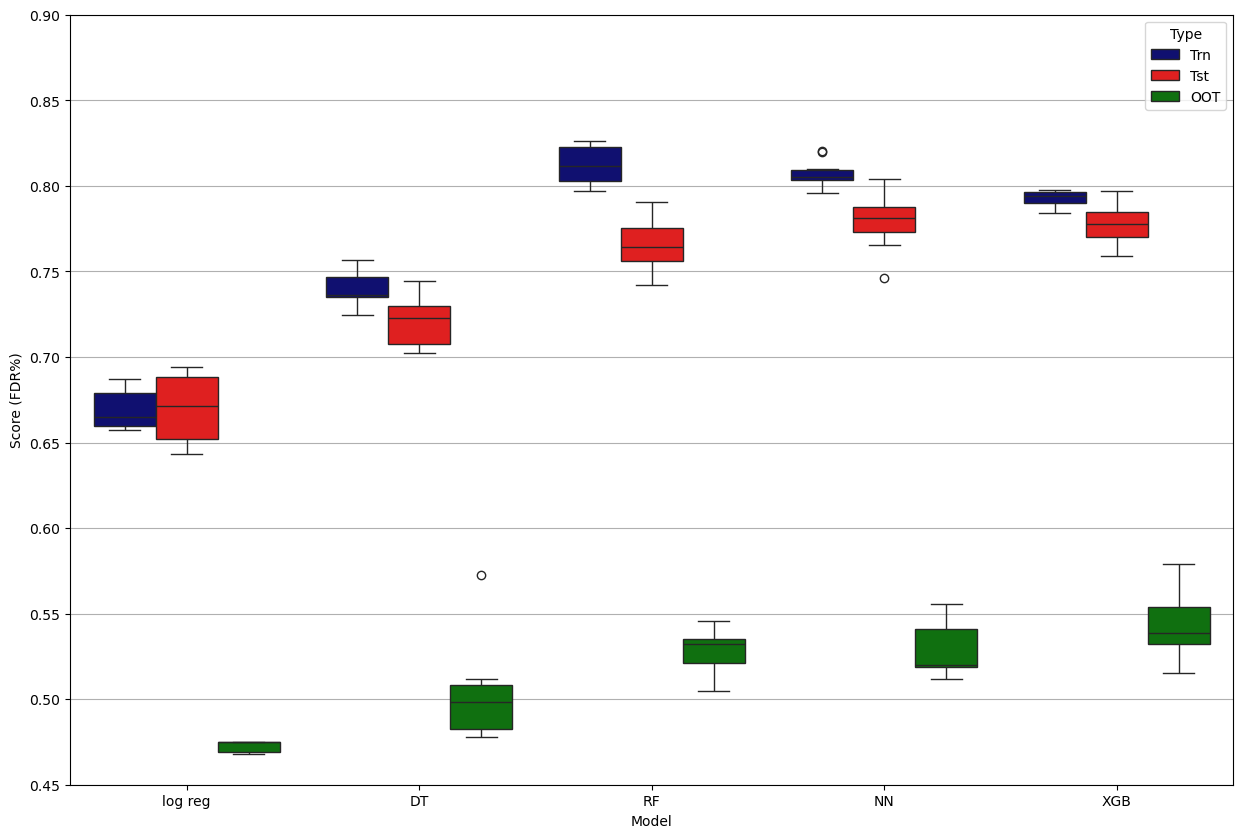

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.45,.9)
plt.ylabel('Score (FDR%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [46]:
print('duration: ', datetime.now() - start_time)

duration:  0:01:16.353162


This next cell can be used to explore overfitting

0 0.7254575707154742 0.7062043795620438 0.49158249158249157
1 0.7202625102543068 0.7288135593220338 0.49158249158249157
2 0.7234910277324633 0.7118320610687023 0.4882154882154882
loop trn tst oot 2 0.7230703695674148 0.7156166666509267 0.49046015712682384
0 0.7558232931726908 0.697029702970297 0.5016835016835017
1 0.7459415584415584 0.7200772200772201 0.5117845117845118
2 0.7349298100743188 0.7365491651205937 0.5218855218855218
loop trn tst oot 3 0.7455648872295226 0.7178853627227036 0.5117845117845118
0 0.7724306688417618 0.7366412213740458 0.5353535353535354
1 0.787676935886761 0.7413479052823315 0.5387205387205387
2 0.7599351175993512 0.7117988394584139 0.5454545454545454
loop trn tst oot 4 0.7733475741092913 0.7299293220382638 0.5398428731762065
0 0.7909604519774012 0.7553816046966731 0.5050505050505051
1 0.7943548387096774 0.792156862745098 0.5858585858585859
2 0.7976973684210527 0.7471910112359551 0.5420875420875421
loop trn tst oot 5 0.7943375530360437 0.7649098262259088 0.54433

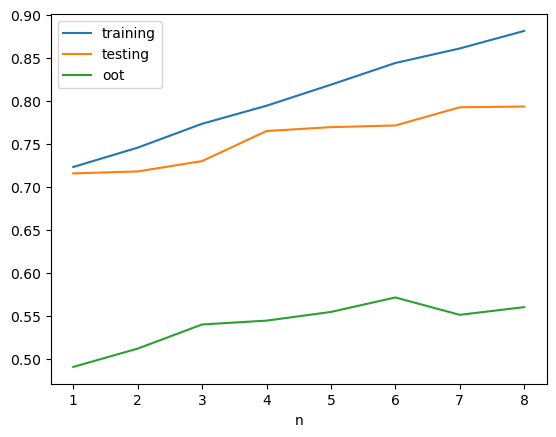

CPU times: user 49.5 s, sys: 7.75 s, total: 57.2 s
Wall time: 7.45 s


In [105]:
%%time
nitermax2 = 3
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(2,10):
    for niter in range(nitermax2):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model = xgb.XGBClassifier(
    max_depth=i,              # Higher maximum depth for more complex trees
    learning_rate=0.03,       # Lower learning rate for gradual convergence
    n_estimators=100,         # Increase boosting rounds
    random_state=42           # Seed for reproducibility
)


        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*detect_rate))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*detect_rate))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*detect_rate))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(1,len(training)+1),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
plt.savefig('complexity_NN.pdf', format='pdf')
plt.show()

In [48]:
best_OOT

0.5791245791245792

The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [49]:
%%time
# Note - need to set this next value to around the highest oot fdr for your model of choice.
# The model then runs a nombermof times with your fixed hyperparameters until it finds a good model.
desire = .52
print('desire =', desire)
for niter in range(50):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
# I run this loop a large number of times with an unreasonably high stopping criterion (the break condition)
# I then look at all these runs and select a value of the oot performance where I want to break out this loop
# and that will be my final model run of choice

    model = lgb.LGBMClassifier()
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
# choose a good break point
    if(FDR.loc[niter, 'oot'] > desire): break
    
model_counter = model_counter + 1

desire = 0.52
[LightGBM] [Info] Number of positive: 1222, number of negative: 58462
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1038
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020474 -> initscore=-3.867888
[LightGBM] [Info] Start training from score -3.867888
0 0.9549918166939444 0.8049242424242424 0.4781144781144781
[LightGBM] [Info] Number of positive: 1226, number of negative: 58458
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1038
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 5
[LightGBM] [I

In [50]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [51]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,predicted,Fraud
94031,7.900037,-0.324574,1.047494,-0.114619,1.512059,0.979761,1
93991,7.256559,-0.327062,0.993776,-0.114619,1.438464,0.977946,1
93921,5.326124,-0.223463,0.812479,-0.114619,1.149747,0.966028,1
96324,7.256559,-0.323033,1.369662,-0.188352,-0.637028,0.963282,1
93866,4.682646,0.086734,0.671471,-0.122573,0.869779,0.960888,1
93907,5.326124,0.194774,0.744249,-0.114619,1.021428,0.960888,1
91007,7.900037,-0.324087,2.305513,-0.185289,2.537923,0.960820,1
90999,7.256559,-0.320464,2.285445,-0.185289,2.530701,0.958008,1
93989,6.613081,-0.221542,0.936899,-0.114619,1.355057,0.957938,1
93940,5.969603,-0.251689,0.876574,-0.114619,1.259734,0.954765,0


In [52]:
cost_fraud = 1000
cost_fp = 30
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud
    FDR_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp
    FDR_trn.loc[i, 'Overall Savings'] = FDR_trn.loc[i, 'Fraud Savings'] - FDR_trn.loc[i, 'FP Loss']
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud
    FDR_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp
    FDR_tst.loc[i, 'Overall Savings'] = FDR_tst.loc[i, 'Fraud Savings'] - FDR_tst.loc[i, 'FP Loss']
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot

    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,122.0,27.0,95.0,22.131148,77.868852,122.0,27.0,95.0,0.226225,31.986532,31.760307,0.284211
2,2.0,123.0,88.0,35.0,71.544715,28.455285,245.0,115.0,130.0,0.963553,43.771044,42.807491,0.884615
3,3.0,122.0,97.0,25.0,79.508197,20.491803,367.0,212.0,155.0,1.776288,52.188552,50.412264,1.367742
4,4.0,122.0,116.0,6.0,95.081967,4.918033,489.0,328.0,161.0,2.748220,54.208754,51.460535,2.037267
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,123.0,123.0,0.0,100.000000,0.000000,11743.0,11447.0,296.0,95.911186,99.663300,3.752114,38.672297
97,97.0,122.0,122.0,0.0,100.000000,0.000000,11865.0,11569.0,296.0,96.933389,99.663300,2.729910,39.084459
98,98.0,122.0,122.0,0.0,100.000000,0.000000,11987.0,11691.0,296.0,97.955593,99.663300,1.707707,39.496622
99,99.0,123.0,122.0,1.0,99.186992,0.813008,12110.0,11813.0,297.0,98.977796,100.000000,1.022204,39.774411


Max possible savings: 44,172,000.0


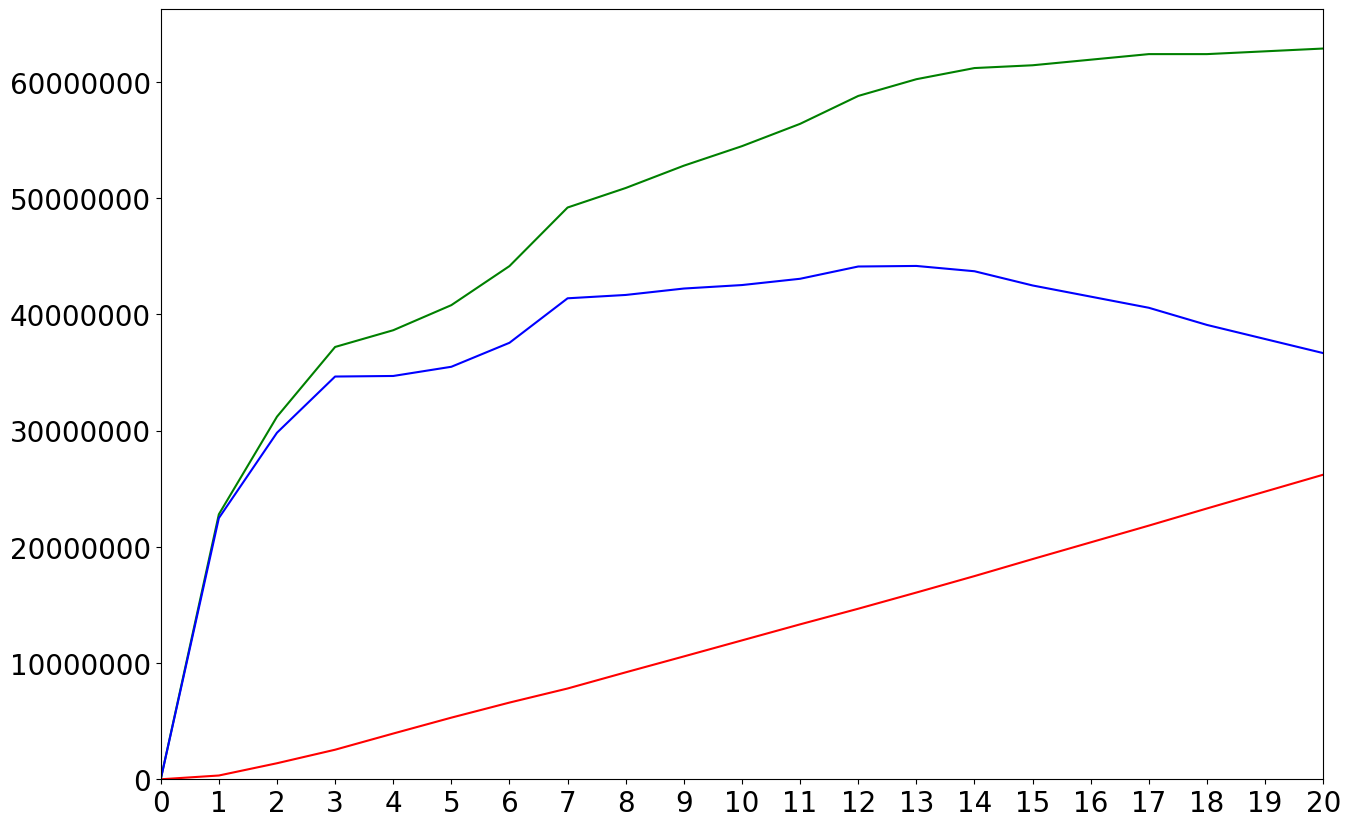

In [53]:
cost_fraud = 400
cost_fp = 20
# xmult: oot is only 2 out of 12 months. 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_trn = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_tst = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud * xoot
    Financials_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp * xoot
    Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'Fraud Savings'] - Financials_trn.loc[i, 'FP Loss']
    Financials_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud * xoot
    Financials_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp * xoot
    Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'Fraud Savings'] - Financials_tst.loc[i, 'FP Loss']
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
xlimit = 20
interval = 1
plt.xlim(0,xlimit)
plt.ylim(0,yupper)
plt.xticks(ticks=np.linspace(0,xlimit, num=int(xlimit/interval)+1))
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')

In [54]:
FDR_oot.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,122.0,27.0,95.0,22.131148,77.868852,122.0,27.0,95.0,0.226225,31.986532,31.760307,0.284211
2,2.0,123.0,88.0,35.0,71.544715,28.455285,245.0,115.0,130.0,0.963553,43.771044,42.807491,0.884615
3,3.0,122.0,97.0,25.0,79.508197,20.491803,367.0,212.0,155.0,1.776288,52.188552,50.412264,1.367742
4,4.0,122.0,116.0,6.0,95.081967,4.918033,489.0,328.0,161.0,2.748220,54.208754,51.460535,2.037267
5,5.0,123.0,114.0,9.0,92.682927,7.317073,612.0,442.0,170.0,3.703393,57.239057,53.535664,2.600000
6,6.0,122.0,108.0,14.0,88.524590,11.475410,734.0,550.0,184.0,4.608295,61.952862,57.344567,2.989130
7,7.0,122.0,101.0,21.0,82.786885,17.213115,856.0,651.0,205.0,5.454545,69.023569,63.569024,3.175610
8,8.0,123.0,116.0,7.0,94.308943,5.691057,979.0,767.0,212.0,6.426477,71.380471,64.953995,3.617925
9,9.0,122.0,114.0,8.0,93.442623,6.557377,1101.0,881.0,220.0,7.381651,74.074074,66.692423,4.004545


In [55]:
FDR.to_csv('FDR.csv')

In [56]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [57]:
Metrics = FDR_oot.copy()
num_good = Metrics['#g'].sum()
num_bad = Metrics['#b'].sum()
num_tot = Metrics['#recs'].sum()
print(num_good,num_bad,num_good+num_bad,num_tot)

11935.0 297.0 12232.0 12232.0


In [58]:
Metrics['TP'] = Metrics['cb']
Metrics['TN'] = num_good - Metrics['cg']
Metrics['FN'] = num_bad - Metrics['cb']
Metrics['FP'] = Metrics['cg']
Metrics['Accuracy'] = (Metrics['TP'] + Metrics['TN']) / num_tot
Metrics['Misclass'] = (Metrics['FP'] + Metrics['FN']) / num_tot
Metrics['FPRate'] = Metrics['FP'] / (Metrics['FP'] + Metrics['TN'])
Metrics['FPRatio'] = Metrics['FP'] / Metrics['TP']
Metrics['TPR'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FN'])
Metrics['TNR'] = Metrics['TN'] / (Metrics['TN'] + Metrics['FP'])
Metrics['Precision'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FP'])
Metrics['f1'] = 2 * Metrics['Precision'] * Metrics['TPR'] / (Metrics['Precision'] + Metrics['TPR'])
Metrics.to_csv('Metrics.csv')

Text(0, 0.5, 'FDR')

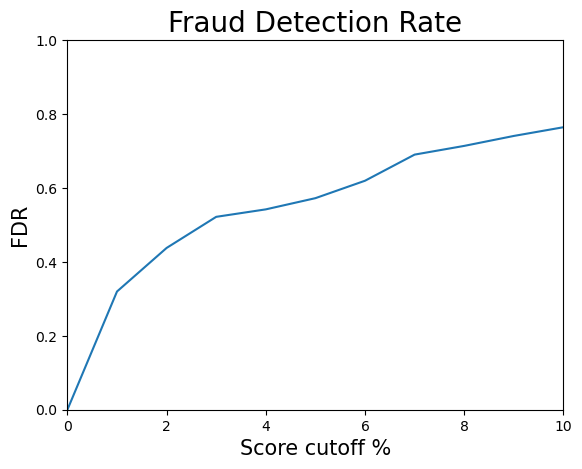

In [59]:
plt.rcParams.update({'font.size':10})
plt.plot(Metrics['bin'], Metrics['TPR'])
plt.title('Fraud Detection Rate', fontsize=20)
plt.xlim(0,10)
plt.ylim(0,1)
plt.xlabel('Score cutoff %', fontsize=15)
plt.ylabel('FDR', fontsize=15)

For a highly imbalanced problem the # goods in each bin is close to constant except for the first few bins, so the FDR curve (xaxis is bin #) and the ROC (x axis is FP, which is # goods below the cutoff) look very similar. They're only different in the first few bins where the # goods are not ~constant.

(0.0, 1.0)

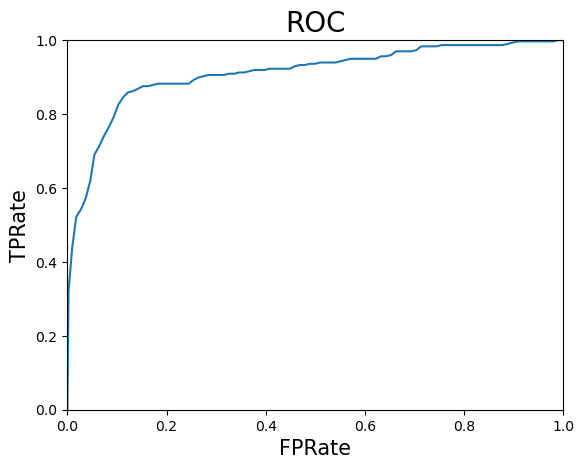

In [60]:
plt.plot(Metrics['FPRate'], Metrics['TPR'])
plt.title('ROC', fontsize=20)
plt.xlabel('FPRate',fontsize=15)
plt.ylabel('TPRate', fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1)

In [61]:
print("duration: ", datetime.now() - start_time)

duration:  0:38:48.019915


In [62]:
%pwd

'/home/jovyan/MGTA463-Fraud-Analysis-2'

In [63]:
%%time
df = pd.read_csv('card transactions.csv')
df.dropna(how='all', axis=1, inplace=True)
df = df[df['Transtype'] == 'P']
df = df[df['Amount'] <= 3000000]
df['Date'] = pd.to_datetime(df['Date'])
df.shape

CPU times: user 105 ms, sys: 16.7 ms, total: 121 ms
Wall time: 143 ms


(97496, 10)

In [64]:
df['prediction'] = model.predict_proba(X)[:,1]

In [65]:
pred_scale = 1/df['prediction'].max()
df['prediction'] = df['prediction']*pred_scale

In [66]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,5142190439,2010-01-01,5.50901E+12,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.000106
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,0.000169
2,3,5142131721,2010-01-01,4.50308E+12,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,0.000568
3,4,5142148452,2010-01-01,5.50901E+12,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,0.000106
4,5,5142190439,2010-01-01,5.50901E+12,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.000063


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97496 entries, 0 to 97851
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             97496 non-null  int64         
 1   Cardnum            97496 non-null  int64         
 2   Date               97496 non-null  datetime64[ns]
 3   Merchnum           94276 non-null  object        
 4   Merch description  97496 non-null  object        
 5   Merch state        96468 non-null  object        
 6   Merch zip          93149 non-null  float64       
 7   Transtype          97496 non-null  object        
 8   Amount             97496 non-null  float64       
 9   Fraud              97496 non-null  int64         
 10  prediction         97496 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 8.9+ MB


In [68]:
df_sorted = df.sort_values(by=['prediction'],ascending=False)
df_sorted.head(20)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
1724,1725,5142184638,2010-01-10,9.01094E+12,ECKERD DRUGS 2939,TX,75202.0,P,13.45,1,1.000000
64408,64409,5142219623,2010-08-16,NaN,RETAIL DEBIT ADJUSTMENT,NaN,NaN,P,17.41,1,0.997713
20520,20521,5142214614,2010-03-20,6.8801E+12,TUDOR SCIENTIFIC GLASS CO,SC,29841.0,P,4670.30,1,0.997187
20545,20546,5142214614,2010-03-20,4.063E+12,PC *PC CONNECTION,NH,97213.0,P,5266.05,1,0.997187
20529,20530,5142214614,2010-03-20,4.5912E+12,DELL MARKETING L.P.,TX,78682.0,P,5131.83,1,0.997163
54883,54884,5142212038,2010-07-18,9.3009E+11,FEDEX SHP 07/25/10 AB#,TN,38118.0,P,31.29,1,0.996826
54784,54785,5142212038,2010-07-18,9.3009E+11,FEDEX SHP 07/05/10 AB#,TN,38118.0,P,42.04,1,0.996826
54840,54841,5142212038,2010-07-18,9.3009E+11,FEDEX SHP 07/13/10 AB#,TN,38118.0,P,41.33,1,0.996378
54793,54794,5142212038,2010-07-18,9.3009E+11,FEDEX SHP 07/25/10 AB#,TN,38118.0,P,31.72,1,0.996335
1749,1750,5142184638,2010-01-10,9.10907E+11,LABCONCO CORPORATION,MO,64132.0,P,13.06,1,0.996278


In [69]:
bads = df[df['Fraud']==1]
bads['Cardnum'].value_counts().head(20)

Cardnum
5142214614    60
5142271065    58
5142140316    46
5142847398    45
5142199009    45
5142219623    44
5142189341    41
5142160778    41
5142225942    41
5142212038    39
5142181728    39
5142220919    38
5142165136    37
5142202847    37
5142138135    36
5142223659    36
5142149994    35
5142226204    35
5142260253    34
5142189108    33
Name: count, dtype: int64

In [70]:
bads['Merchnum'].value_counts().head(15)

Merchnum
9.3009E+11     151
4.353E+12      116
9.10823E+12     64
8.834E+12       51
4.62001E+12     50
4.50308E+12     50
4.50374E+12     45
9.90002E+12     45
9.00009E+11     43
6.18902E+11     36
2.53053E+11     34
9.3891E+11      32
6.0701E+12      31
9.97675E+11     30
6.00633E+12     30
Name: count, dtype: int64

In [71]:
card = 5142140316
# card = 5142847398
# card = 5142199009
# card = 5142160778
# card = 5142189341
# card = 5142181728
# card = 5142212038
# card = 5142220919
# card = 5142214614
# card = 5142202847
# card = 5142138135
# card = 5142271065
# card = 5142152857
# card = 5142179617
# card = 5142235211
# card = 5142197711
# card = 5142182128
# card = 5142189113
# card = 5142197563 

merch = 4353000719908
# merch = 930090121224  
# merch = 48834000695423
# merch = 44503738417400
# merch = 44620009957157
# merch = 4618901687330
# merch = 4900009045549
# merch = 49108234610000
# merch = 4253052983001
# merch = 4938909877224
# merch = 44503082476300
# merch = 46006333528866
# merch = 4997674930332
# merch = 46070095870009
# merch = 49900020006406
# sample = df[df['Cardnum'] == card]
sample = df[df['Merchnum'] == str(merch)]
sample['Fraud'].sum()

0

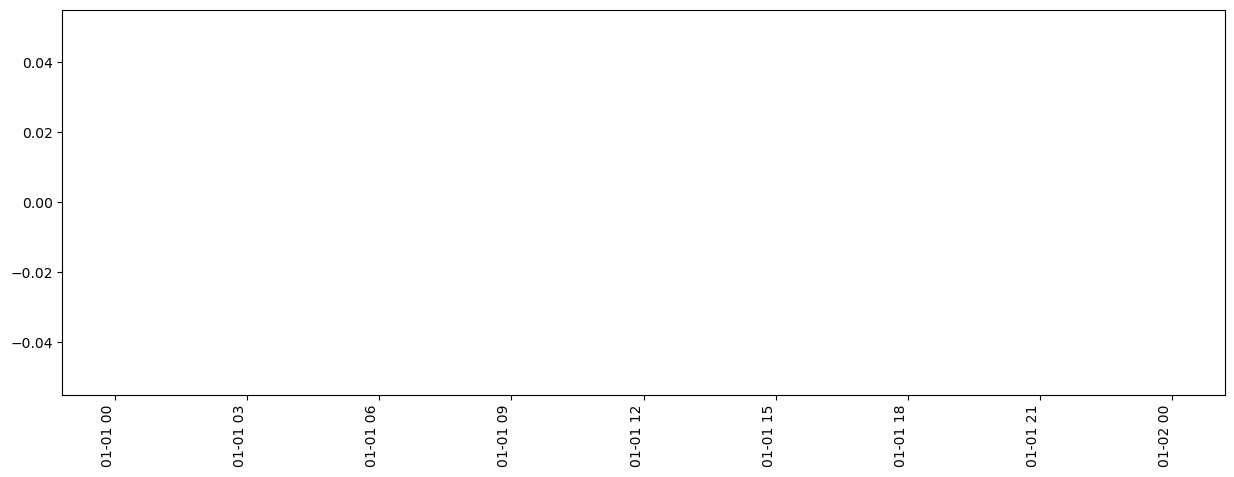

In [72]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(sample['Date'],sample['prediction'])
plt.plot_date(sample['Date'],sample['Fraud'])

In [73]:
tsample = sample[sample['Date'] > '2010-11-09']
tsample = tsample[tsample['Date'] < '2010-12-01']
tsample.reset_index(inplace=True)
tsample.reset_index(inplace=True)
tsample.rename(columns={'level_0':'counter'},inplace=True)
tsample['counter'] = tsample['counter']+1
tsample.head()

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction


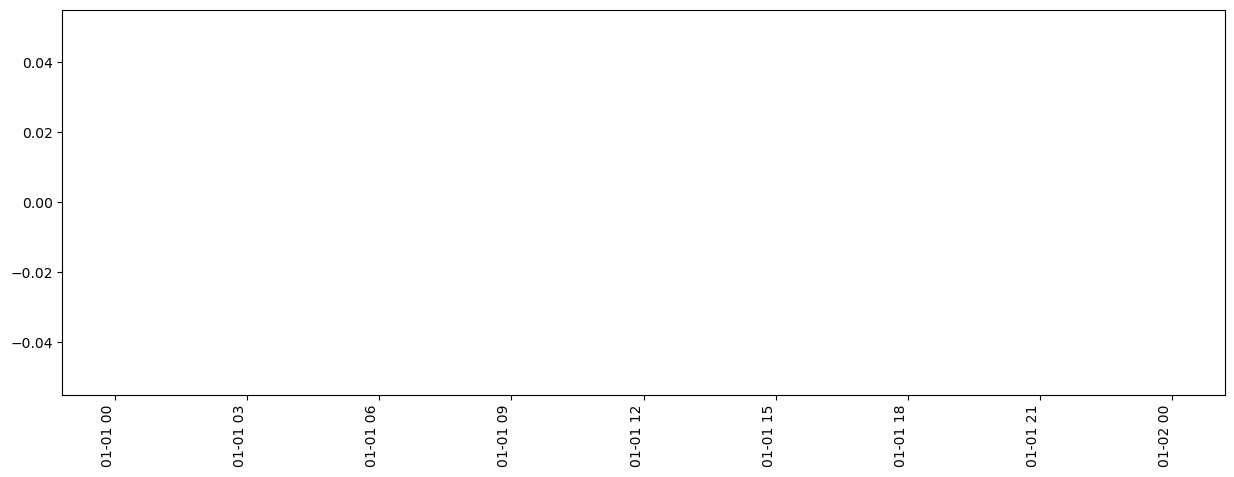

In [74]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['Date'],tsample['prediction'])
plt.plot_date(tsample['Date'],tsample['Fraud'])

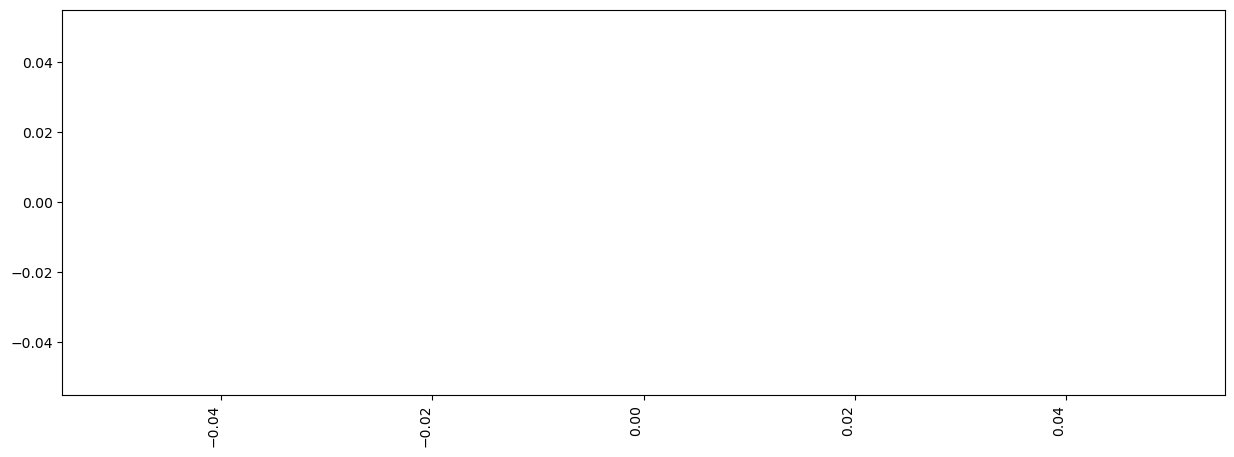

In [75]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['counter'],tsample['prediction'])
plt.scatter(tsample['counter'],tsample['Fraud'])

In [76]:
tsample.head(40)

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction


# Score Calibration

In [77]:
base = 700
delta = 40
odds_at_base = 1

In [78]:
df = pd.concat([X_trn_eval,X_tst_eval,X_oot_eval])
df.shape

(97496, 7)

In [79]:
df.head()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,predicted,Fraud
47109,0.178299,-0.278925,-0.556134,-0.655622,-0.614942,0.000130,0
83369,-0.465180,-0.133274,-0.655670,-0.105069,-0.438198,0.000685,0
37287,-0.465180,-0.279760,-0.390242,-0.500623,-0.609647,0.000561,0
80361,-0.465180,-0.053711,-0.769425,2.611043,-0.618914,0.055389,0
58673,0.178299,-0.200861,0.083737,-0.437663,2.689572,0.001950,0


In [80]:
calib = df.iloc[:,df.shape[1]-2:]
trn_sorted = X_trn_eval.sort_values('predicted',ascending=True)
calib = calib.sort_values('predicted')
calib.rename(columns={'predicted':'score_raw'}, inplace=True)
calib['score_raw'].clip(upper=.999, inplace=True)
calib['score_raw'].clip(lower=.00001, inplace=True)
calib.head()

,score_raw,Fraud
14076,0.00001,0
43956,0.00001,0
12601,0.00001,0
12771,0.00001,0
14068,0.00001,0


In [81]:
calib.shape

(97496, 2)

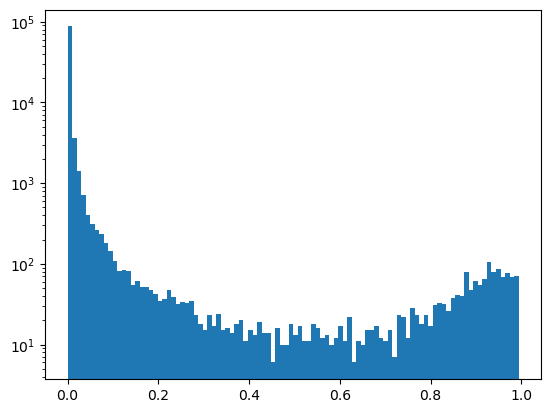

In [82]:
plt.hist(calib['score_raw'],bins=100)
plt.yscale('log')

In [83]:
# The reason we bin the records is to calculate the odds. We can then find the relationship between the raw score and the log odds.
nbins=100
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','score_raw','prob(%)','odds','log_odds', 'log_odds_adj']
cal_bins = pd.DataFrame(np.zeros((nbins+1, 14)), columns = cols)

In [84]:
bad_tot = sum(calib.loc[:, 'Fraud'])
good_tot = len(calib) - bad_tot
print(bad_tot, good_tot)

2047 95449


In [85]:
frac = 1/nbins
nrecs = calib.shape[0]
cal_bins.loc[0,'log_odds_adj'] = -8
for i in range(nbins+1):
    percent_rows_top = int(round(nrecs*frac*i))
    percent_rows_bottom = max(int(round(nrecs*frac*(i-1))),0)
    temp = calib.iloc[percent_rows_bottom:percent_rows_top,:]
    cal_bins.loc[i, 'score_raw'] = temp['score_raw'].mean()
    num_bad = int(sum(temp.loc[:,'Fraud']))
    num_tot = len(temp) * i
    num_good = int(num_tot - num_bad)
    cal_bins.loc[i, 'bin'] = i
    cal_bins.loc[i,'#recs'] = 0
    cal_bins.loc[i, 'tot'] = num_tot
    cal_bins.loc[i, 'cg'] = num_good
    cal_bins.loc[i, 'cb'] = num_bad
    if i != 0:
        cal_bins.loc[i, '#recs'] = len(temp)
        cal_bins.loc[i, '#b'] = int(sum(temp.loc[:, 'Fraud']))
        cal_bins.loc[i, '#g'] = cal_bins.loc[i, '#recs'] - cal_bins.loc[i, '#b']
        cal_bins.loc[i, '%g'] = 100* cal_bins.loc[i, '#g'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, '%b'] = 100 - cal_bins.loc[i, '%g']
        cal_bins.loc[i, 'cg'] = cal_bins.loc[i-1, 'cg'] + cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'cb'] = cal_bins.loc[i-1, 'cb'] + cal_bins.loc[i, '#b']
        cal_bins.loc[i, 'prob(%)'] = 100 * cal_bins.loc[i, '#b'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, 'odds'] = (cal_bins.loc[i, '#b'] + .001) / cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'log_odds'] = np.log(cal_bins.loc[i, 'odds'])
        cal_bins.loc[i, 'log_odds_adj'] = max(cal_bins.loc[i, 'log_odds'], cal_bins.loc[i-1, 'log_odds_adj'])
        
cal_bins.drop(index=0,axis=0,inplace=True)
cal_bins.fillna(0)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
1,1.0,975.0,975.0,0.0,100.000000,0.000000,975.0,975.0,0.0,0.000018,0.000000,0.000001,-13.790193,-8.000000
2,2.0,975.0,975.0,0.0,100.000000,0.000000,1950.0,1950.0,0.0,0.000034,0.000000,0.000001,-13.790193,-8.000000
3,3.0,975.0,975.0,0.0,100.000000,0.000000,2925.0,2925.0,0.0,0.000047,0.000000,0.000001,-13.790193,-8.000000
4,4.0,975.0,974.0,1.0,99.897436,0.102564,3900.0,3899.0,1.0,0.000059,0.102564,0.001028,-6.880412,-6.880412
5,5.0,975.0,975.0,0.0,100.000000,0.000000,4875.0,4874.0,1.0,0.000072,0.000000,0.000001,-13.790193,-6.880412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,975.0,939.0,36.0,96.307692,3.692308,93600.0,93356.0,240.0,0.041224,3.692308,0.038340,-3.261269,-3.261269
97,97.0,975.0,920.0,55.0,94.358974,5.641026,94575.0,94276.0,295.0,0.071679,5.641026,0.059784,-2.817022,-2.817022
98,98.0,975.0,808.0,167.0,82.871795,17.128205,95550.0,95084.0,462.0,0.164001,17.128205,0.206684,-1.576562,-1.576562
99,99.0,975.0,322.0,653.0,33.025641,66.974359,96525.0,95406.0,1115.0,0.572316,66.974359,2.027953,0.707027,0.707027


In [86]:
cal_bins.tail()

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
96,96.0,975.0,939.0,36.0,96.307692,3.692308,93600.0,93356.0,240.0,0.041224,3.692308,0.038340,-3.261269,-3.261269
97,97.0,975.0,920.0,55.0,94.358974,5.641026,94575.0,94276.0,295.0,0.071679,5.641026,0.059784,-2.817022,-2.817022
98,98.0,975.0,808.0,167.0,82.871795,17.128205,95550.0,95084.0,462.0,0.164001,17.128205,0.206684,-1.576562,-1.576562
99,99.0,975.0,322.0,653.0,33.025641,66.974359,96525.0,95406.0,1115.0,0.572316,66.974359,2.027953,0.707027,0.707027
100,100.0,975.0,43.0,932.0,4.410256,95.589744,97500.0,95449.0,2047.0,0.927690,95.589744,21.674442,3.076134,3.076134


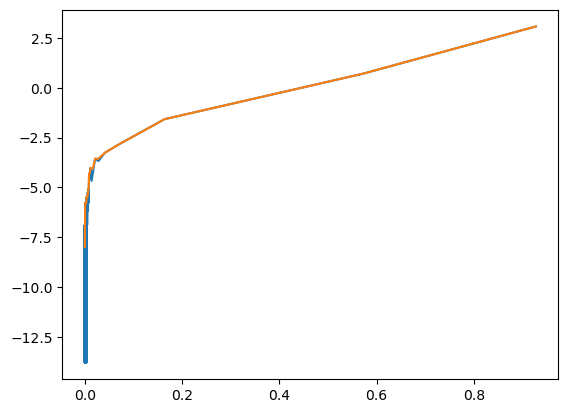

In [87]:
plt.plot(cal_bins['score_raw'],cal_bins['log_odds'])
plt.plot(cal_bins['score_raw'],cal_bins['log_odds_adj'])
# plt.xlim([0,1])

In [88]:
def func(x, a, b, c):
    return c + b/(1 + np.exp(-a * x))

def funcinv(x, a, b, c):
    return -np.log(-1 + b/(x - c))/a

In [89]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, cal_bins['log_odds_adj'],cal_bins['score_raw'])   
print(popt)

[ 0.93933786  0.94428577 -0.00236898]


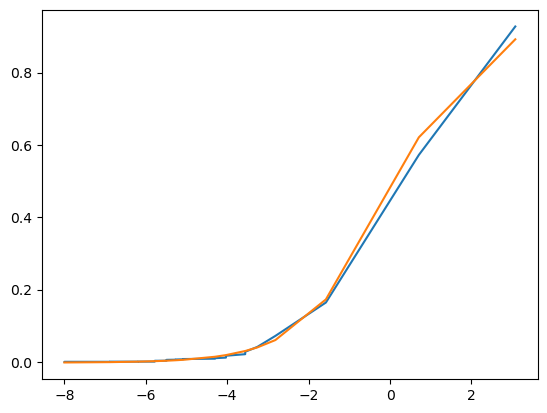

In [90]:
# plt.plot(cal_bins['log_odds'],cal_bins['score'])
plt.plot(cal_bins['log_odds_adj'],cal_bins['score_raw'])
plt.plot(cal_bins['log_odds_adj'],func(cal_bins['log_odds_adj'], *popt))

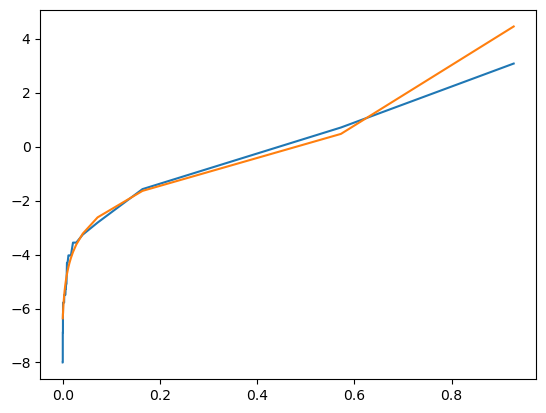

In [91]:
# look at the smooth curve fit to see if it's OK.
plt.plot(cal_bins['score_raw'], cal_bins['log_odds_adj'])
plt.plot(cal_bins['score_raw'], funcinv(cal_bins['score_raw'], *popt))

In [92]:
# The fit looks pretty good
cal_bins['fit'] = funcinv(cal_bins['score_raw'], *popt)
cal_bins.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit
1,1.0,975.0,975.0,0.0,100.000000,0.000000,975.0,975.0,0.0,0.000018,0.000000,0.000001,-13.790193,-8.000000,-6.363861
2,2.0,975.0,975.0,0.0,100.000000,0.000000,1950.0,1950.0,0.0,0.000034,0.000000,0.000001,-13.790193,-8.000000,-6.356909
3,3.0,975.0,975.0,0.0,100.000000,0.000000,2925.0,2925.0,0.0,0.000047,0.000000,0.000001,-13.790193,-8.000000,-6.351172
4,4.0,975.0,974.0,1.0,99.897436,0.102564,3900.0,3899.0,1.0,0.000059,0.102564,0.001028,-6.880412,-6.880412,-6.345839
5,5.0,975.0,975.0,0.0,100.000000,0.000000,4875.0,4874.0,1.0,0.000072,0.000000,0.000001,-13.790193,-6.880412,-6.339869
6,6.0,975.0,975.0,0.0,100.000000,0.000000,5850.0,5849.0,1.0,0.000086,0.000000,0.000001,-13.790193,-6.880412,-6.334014
7,7.0,975.0,974.0,1.0,99.897436,0.102564,6825.0,6823.0,2.0,0.000095,0.102564,0.001028,-6.880412,-6.880412,-6.330173
8,8.0,975.0,975.0,0.0,100.000000,0.000000,7800.0,7798.0,2.0,0.000104,0.000000,0.000001,-13.790193,-6.880412,-6.326047
9,9.0,975.0,975.0,0.0,100.000000,0.000000,8775.0,8773.0,2.0,0.000116,0.000000,0.000001,-13.790193,-6.880412,-6.320910
10,10.0,975.0,975.0,0.0,100.000000,0.000000,9750.0,9748.0,2.0,0.000126,0.000000,0.000001,-13.790193,-6.880412,-6.316897


In [93]:
# Here's the calibrated score
cal_bins['score_calib'] = base + delta * cal_bins['fit'] - delta * np.log2(odds_at_base)
cal_bins['score_calib'].fillna(999, inplace=True)
cal_bins['score_calib'].clip(upper=999, inplace=True)

In [94]:
calib.head()

,score_raw,Fraud
14076,0.00001,0
43956,0.00001,0
12601,0.00001,0
12771,0.00001,0
14068,0.00001,0


In [95]:
calib['score_calib'] = base - delta * np.log2(odds_at_base) + delta * funcinv(calib['score_raw'], *popt)
calib['score_calib'].fillna(999, inplace=True)
calib['score_calib'].clip(upper=999, inplace=True)
calib.head()

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,score_raw,Fraud,score_calib
14076,0.00001,0,445.299936
43956,0.00001,0,445.299936
12601,0.00001,0,445.299936
12771,0.00001,0,445.299936
14068,0.00001,0,445.299936


In [96]:
calib.tail()

,score_raw,Fraud,score_calib
20496,0.991123,1,999.0
20487,0.991147,1,999.0
20512,0.991147,1,999.0
64186,0.991670,1,999.0
1720,0.993943,1,999.0


In [97]:
calib.describe()

,score_raw,Fraud,score_calib
count,97496.000000,97496.000000,97496.000000
mean,0.020198,0.020996,478.743520
std,0.110552,0.143371,60.234329
min,0.000010,0.000000,445.299936
25%,0.000311,0.000000,450.384975
50%,0.001043,0.000000,460.706341
75%,0.003271,0.000000,482.206849
max,0.993943,1.000000,999.000000


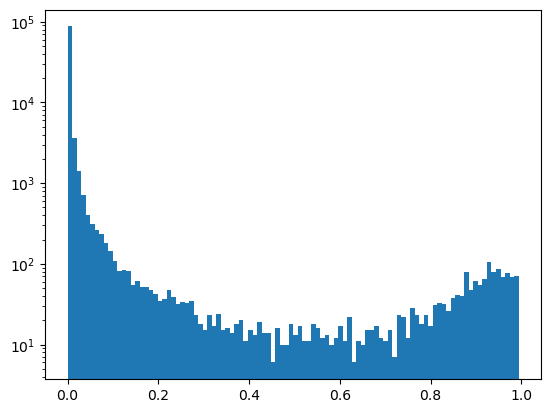

In [98]:
nbins=100
plt.hist(calib['score_raw'],bins=nbins)
plt.yscale('log')

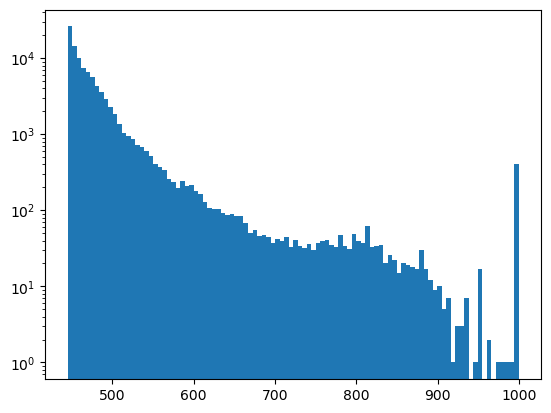

In [99]:
plt.hist(calib['score_calib'],bins=nbins)
plt.yscale('log')

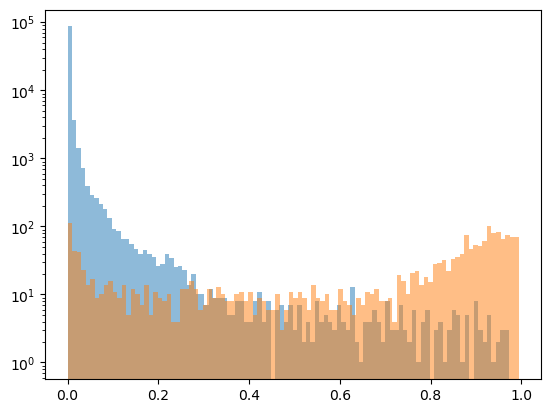

In [100]:
goods = calib[calib['Fraud']==0]
bads = calib[calib['Fraud']==1]
plt.hist(goods['score_raw'],bins = nbins, alpha = .5)
plt.hist(bads['score_raw'],bins = nbins, alpha = .5)
plt.yscale('log')

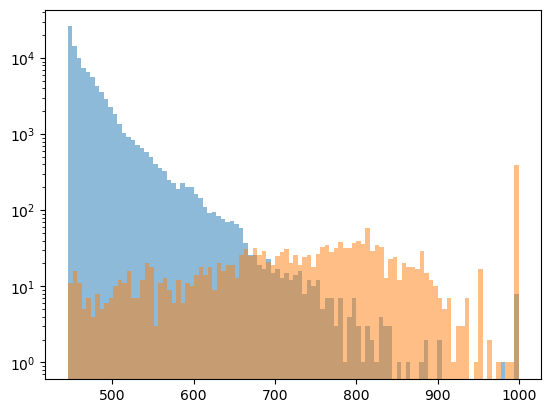

In [101]:
plt.hist(goods['score_calib'],bins = nbins, alpha = .5)
plt.hist(bads['score_calib'],bins = nbins, alpha = .5)
plt.yscale('log')

In [102]:
print("duration: ", datetime.now() - start_time)

duration:  0:38:50.577979


In [103]:
%pwd

'/home/jovyan/MGTA463-Fraud-Analysis-2'